<p style="font-size: 36px; text-align: center; font-family: Arial, sans-serif;">24Fall Advanced Control for Robotics</p>

<br>

<p style="font-size: 24px; text-align: center; font-family: Arial, sans-serif;">miniProject: Train a MLP model based on MNIST dataset</p>

<p style="font-size: 16px; text-align: center; font-family: Arial, sans-serif;">Name: Siyuan Wang  SID: 12443028</p>

#### Prepare MNIST Dataset

In [1]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


if torch.cuda.is_available():
    print("CUDA is available. Number of CUDA devices:", torch.cuda.device_count())
    for device_id in range(torch.cuda.device_count()):
        print("Device ID:", device_id, "Device name:", torch.cuda.get_device_name(device_id))
else:
    print("CUDA is not available. Using CPU instead.")

CUDA is available. Number of CUDA devices: 2
Device ID: 0 Device name: NVIDIA GeForce RTX 4090
Device ID: 1 Device name: NVIDIA GeForce RTX 4090


In [2]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

In [3]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=64)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=32)

In [4]:
for batch_idx, data in enumerate(train_loader):
    # Check data is on which device 
    if data[0].is_cuda:
        print(f"Batch {batch_idx} is on CUDA (GPU)")
    else:
        print(f"Batch {batch_idx} is on CPU")
    # Only check the first batch
    break

Batch 0 is on CPU


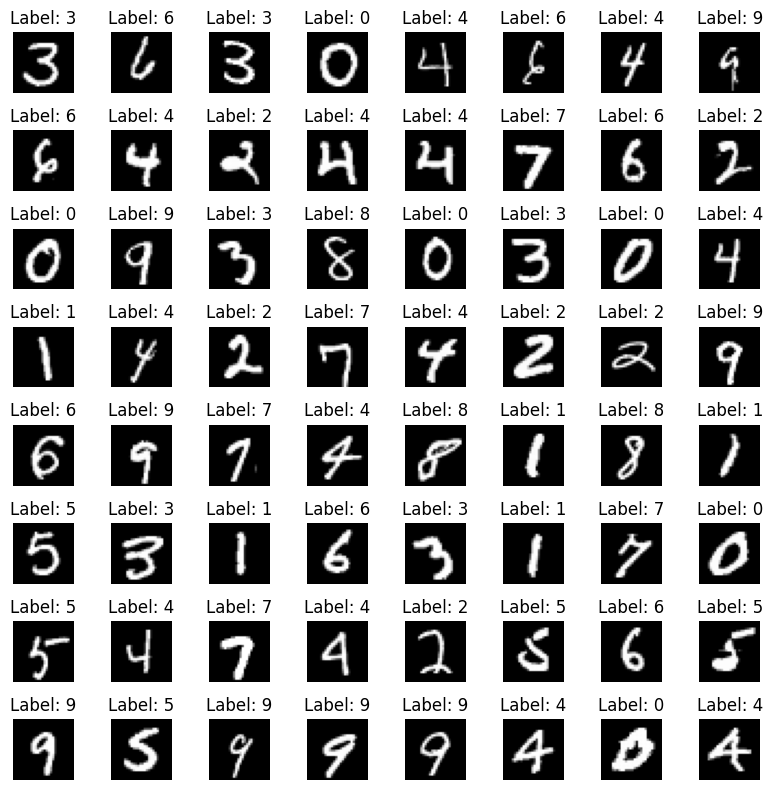

In [20]:
import matplotlib.pyplot as plt
# Function to show images
def show_images(images, labels):
    # Create a grid of 8x8 images
    images, labels = images.to("cpu"), labels.to("cpu")
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    axes = axes.flatten()
    
    # Loop through each image and display it
    for img, ax, label in zip(images, axes, labels):
        img = img.numpy().squeeze()  # Convert to numpy and remove unnecessary dimensions
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show the first 64 images and labels
show_images(images[:64], labels[:64])

#### Construct a MLP (with dropouts), Criterion & Optimizer

In [6]:
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, dropout_prob=0.2):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_prob)
       
    def forward(self, x):
        x = x.view(-1, 28*28) # Flatten the input
        x = self.dropout(self.fc1(x))
        x = torch.relu(x)
        x = self.dropout(self.fc2(x))
        x = torch.relu(x)
        x = self.fc3(x)
        return x

my_model = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9, dampening=0.1, weight_decay=0.0005)

#### Define utility functions

In [7]:
# Declare tensorboard SummaryWriter
writer = SummaryWriter('./log')

In [8]:
def train(model, train_loader, criterion, optimizer, epochs=1, test_every_n_epochs=0):
    model.train()  # Set the nn.module model to "train" mode
    for epoch_0 in range(epochs):
        training_loss = 0.0
        epoch = epoch_0 + 1
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        print('Epoch {}, Loss {}'.format(epoch, training_loss/len(train_loader)))
        writer.add_scalar('training_loss', training_loss, epoch)
        if test_every_n_epochs != 0 and epoch %test_every_n_epochs == 0:
            test(model=model, test_loader=test_loader, clean_test=False, epoch=epoch)

In [9]:
def test(model, test_loader, clean_test=True, epoch=None):
    model.eval()  # This Function is NEEDED to Call before Testing!!!
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    if clean_test == False:
        writer.add_scalar('testing_accuracy', accuracy, epoch)
    else:
        show_images(images[:64], predicted[:64])

In [15]:
def save_model(model):
    import datetime
    now = datetime.datetime.now()
    torch.save(model, "my_simpleMLP_model_{}_{}_{}_{}_{}_{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second))

#### Train, then Test 

-  Train this simpleMLP for 120 epoches

In [11]:
train(model=my_model, train_loader=train_loader, criterion=criterion, optimizer=optimizer, epochs=150, test_every_n_epochs=10)         

Epoch 1, Loss 1.2745358663390693
Epoch 2, Loss 0.5306923572919262
Epoch 3, Loss 0.4218244421869707
Epoch 4, Loss 0.3625748970631216
Epoch 5, Loss 0.3224547675280556
Epoch 6, Loss 0.2946550121455431
Epoch 7, Loss 0.26887119128537584
Epoch 8, Loss 0.2518350677465452
Epoch 9, Loss 0.23188821183465946
Epoch 10, Loss 0.21739036338860546
Accuracy: 95.0%
Epoch 11, Loss 0.15345677713563702
Epoch 12, Loss 0.14101509250867278
Epoch 13, Loss 0.13155750380848835
Epoch 14, Loss 0.12319043572189839
Epoch 15, Loss 0.11610287907066694
Epoch 16, Loss 0.1098599271612492
Epoch 17, Loss 0.1039449668485425
Epoch 18, Loss 0.09854012502949121
Epoch 19, Loss 0.09401631361937948
Epoch 20, Loss 0.08951483455115258
Accuracy: 96.94%
Epoch 21, Loss 0.0856638228270545
Epoch 22, Loss 0.08195361445870386
Epoch 23, Loss 0.07850473792627771
Epoch 24, Loss 0.07558456829179135
Epoch 25, Loss 0.07255330646454271
Epoch 26, Loss 0.06973504316685264
Epoch 27, Loss 0.06681222720061744
Epoch 28, Loss 0.06452211366096602
Epoch 

Save the trained model

In [16]:
save_model(my_model)

Through observing the logged tensorboard data, the training loss is still decreasing, while the testing accuracy stays around.

Perhaps the limit of this model has been reached, we encountered an overfitting!

-  Test this model, after training for 150 epochs

In [18]:
model_path = 'my_simpleMLP_model_2024_9_29_16_6_41_.pth'
loaded_model = torch.load(model_path, map_location=device)
loaded_model.to(device)

/tmp/ipykernel_2127915/3600639568.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(model_path, map_location=device)


SimpleMLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Accuracy: 98.11%


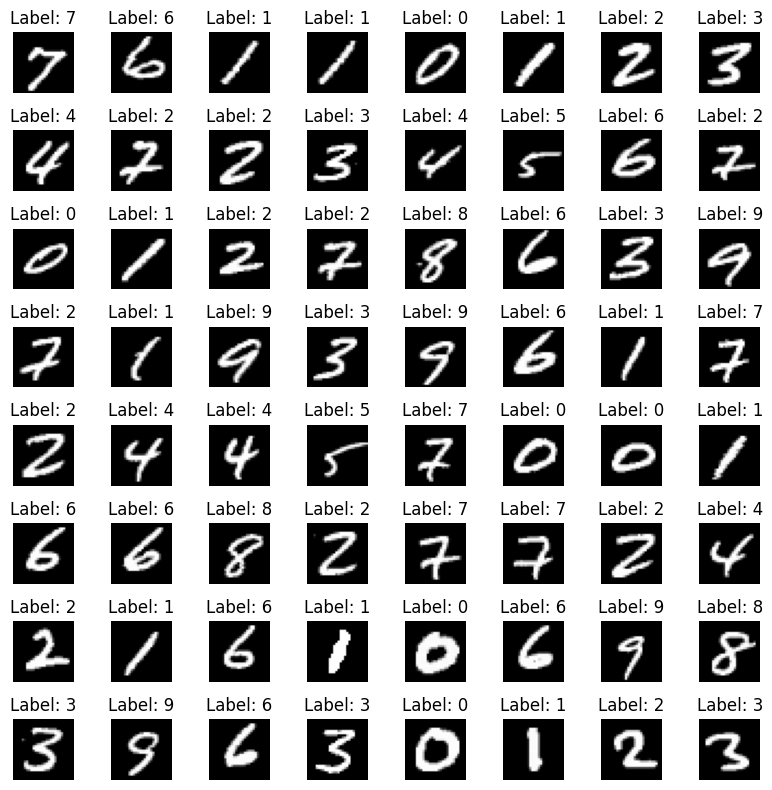

In [21]:
test(model=my_model, test_loader=test_loader)